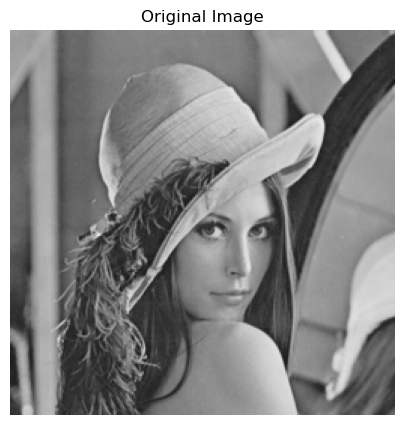

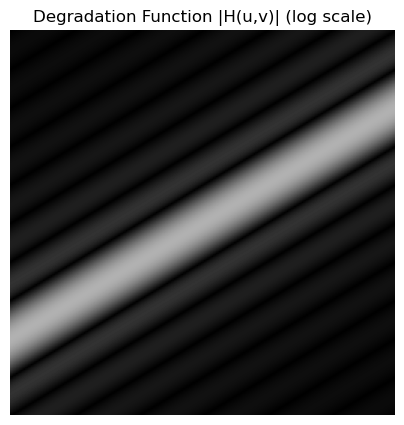

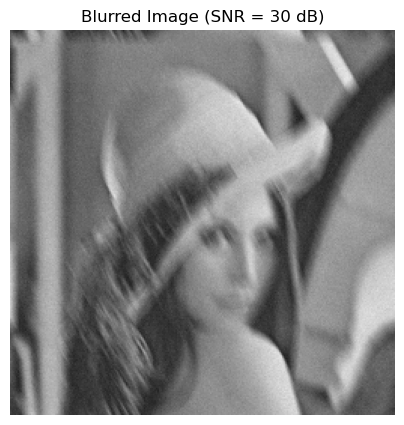

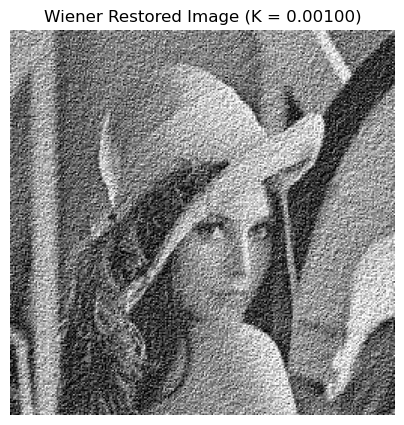

In [250]:
# ============================================================
#   UNIFORM LINEAR MOTION BLUR AND WIENER RESTORATION
# ============================================================
# Formula:
#   H(u,v) = (T / (pi*(u*a + v*b))) * sin(pi*(u*a + v*b)) * exp(-j*pi*(u*a + v*b))
# ------------------------------------------------------------
# Steps:
#   1. Create or load an image
#   2. Generate degradation function H(u,v)
#   3. Blur the image using H(u,v)
#   4. Restore it using the Wiener filter
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ============================================================
# 1️⃣  Load or create a test image
# ============================================================
def load_image(path=None, size=256):
    if path:
        img = Image.open(path).convert('L')
        img = img.resize((size, size))
        img = np.array(img, dtype=np.float32) / 255.0
    else:
        # Synthetic test image (if no file)
        x = np.linspace(0, 1, size)
        y = np.linspace(0, 1, size)
        X, Y = np.meshgrid(x, y)
        img = 0.5 * (np.sin(20 * np.pi * X) + np.cos(20 * np.pi * Y))
        img = (img - img.min()) / (img.max() - img.min())
    return img

# ============================================================
# 2️⃣  Create degradation function H(u,v)
# ============================================================
def make_H_motion(M, N, a, b, T):
    u = np.fft.fftfreq(M)
    v = np.fft.fftfreq(N)
    U, V = np.meshgrid(u, v, indexing='ij')
    arg = (U * a + V * b)
    eps = 1e-12
    x = np.pi * arg
    sinc = np.sin(x) / np.where(np.abs(x) < eps, 1.0, x)
    sinc = np.where(np.abs(x) < eps, 1.0, sinc)
    H = T * sinc * np.exp(-1j * x)
    return H

# ============================================================
# 3️⃣  Degrade image using H(u,v)
# ============================================================
def apply_degradation(img, H, snr_db=None):
    F = np.fft.fft2(img)
    G = H * F
    g = np.fft.ifft2(G).real
    g = np.clip(g, 0, 1)

    # Add Gaussian noise
    if snr_db:
        signal_power = np.mean(g**2)
        snr_linear = 10 ** (snr_db / 10)
        noise_power = signal_power / snr_linear
        noise = np.random.normal(0, np.sqrt(noise_power), g.shape)
        g = np.clip(g + noise, 0, 1)
    return g

# ============================================================
# 4️⃣  Wiener filter restoration
# ============================================================
def wiener_restore(blurred, H, K):
    G = np.fft.fft2(blurred)
    H_conj = np.conj(H)
    F_hat = (H_conj / (np.abs(H)**2 + K)) * G
    f_hat = np.fft.ifft2(F_hat).real
    return np.clip(f_hat, 0, 1)

# ============================================================
# 5️⃣  Visualization helper
# ============================================================
def show(im, title):
    plt.figure(figsize=(5,5))
    plt.imshow(im, cmap='gray', vmin=0, vmax=1)
    plt.title(title)
    plt.axis('off')
    plt.show()

# ============================================================
# 6️⃣  MAIN EXECUTION
# ============================================================
# Load image (replace 'Lena.png' if desired)
img = load_image('Lena.jpg', size=256)

# Motion parameters (try changing a,b,T)
a, b, T = 10, 6, 1.0
H = make_H_motion(*img.shape, a, b, T)

# Apply degradation (blur + optional noise)
snr_db = 30  # set None for no noise
blurred = apply_degradation(img, H, snr_db=snr_db)

# Wiener restoration
K = 10 ** (-snr_db / 10)
restored = wiener_restore(blurred, H, K)

# ============================================================
# 7️⃣  DISPLAY RESULTS
# ============================================================
show(img, "Original Image")
show(np.log1p(np.abs(np.fft.fftshift(H))), "Degradation Function |H(u,v)| (log scale)")
show(blurred, f"Blurred Image (SNR = {snr_db} dB)")
show(restored, f"Wiener Restored Image (K = {K:.5f})")


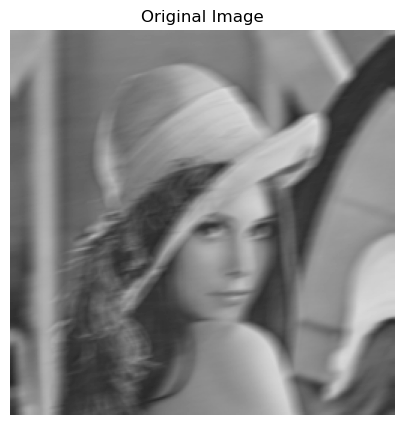

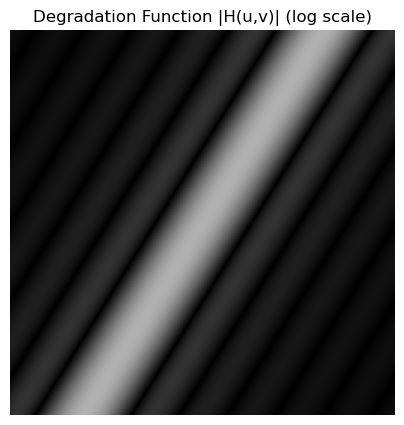

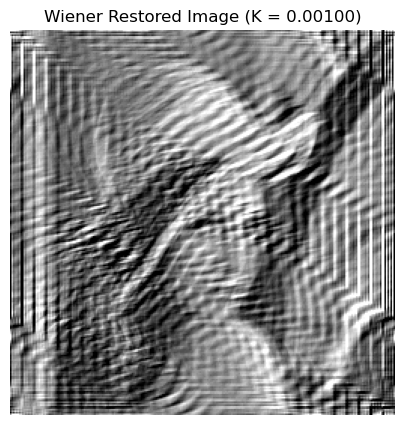

In [276]:
# Load image (replace 'Lena.png' if desired)
blurred = load_image('blurred.png', size=256)

# Motion parameters (try changing a,b,T)
a, b, T = 5, 8, 1.0
H = make_H_motion(*img.shape, a, b, T)

# Wiener restoration
K = 10 ** (-snr_db / 10)
restored = wiener_restore(blurred, H, K)

# ============================================================
# 7️⃣  DISPLAY RESULTS
# ============================================================
show(blurred, "Original Image")
show(np.log1p(np.abs(np.fft.fftshift(H))), "Degradation Function |H(u,v)| (log scale)")
show(restored, f"Wiener Restored Image (K = {K:.5f})")


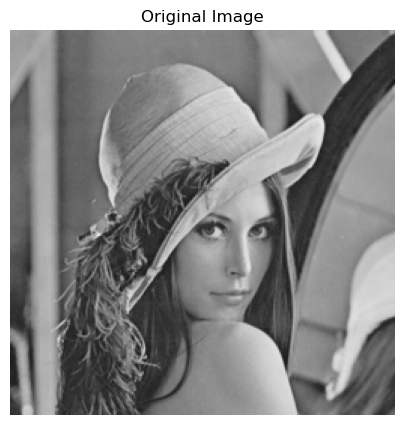

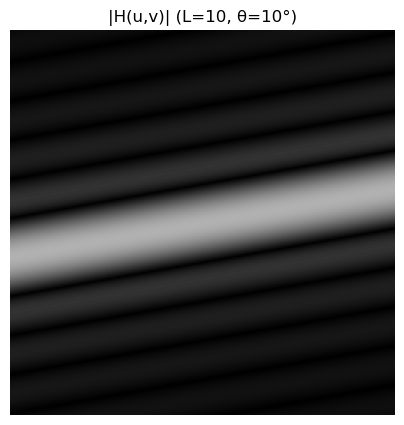

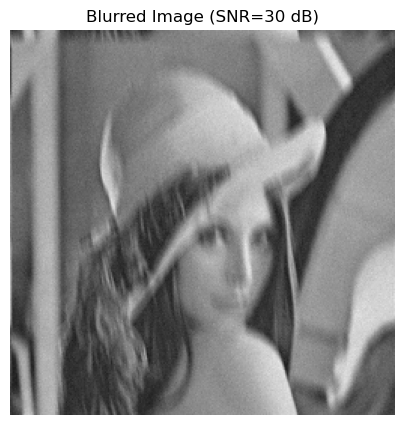

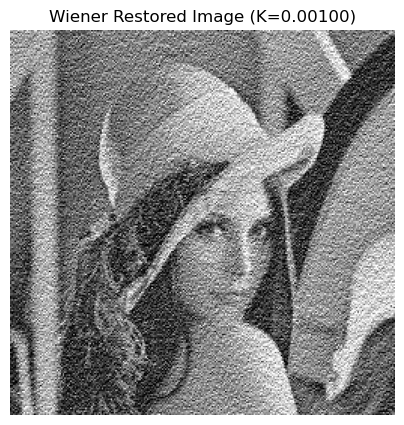

In [296]:
# ============================================================
#   UNIFORM LINEAR MOTION BLUR (L, θ) AND WIENER RESTORATION
# ============================================================
# Formula:
#   H(u,v) = (T / (pi*(u*a + v*b))) * sin(pi*(u*a + v*b)) * exp(-j*pi*(u*a + v*b))
# with:
#   a = (L * cosθ) / T
#   b = (L * sinθ) / T
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ============================================================
# 1️⃣ Load or create a test image
# ============================================================
def load_image(path=None, size=256):
    if path:
        img = Image.open(path).convert('L')
        img = img.resize((size, size))
        img = np.array(img, dtype=np.float32) / 255.0
    else:
        # synthetic pattern (if no file)
        x = np.linspace(0, 1, size)
        y = np.linspace(0, 1, size)
        X, Y = np.meshgrid(x, y)
        img = 0.5 * (np.sin(20 * np.pi * X) + np.cos(20 * np.pi * Y))
        img = (img - img.min()) / (img.max() - img.min())
    return img

# ============================================================
# 2️⃣  Create degradation function H(u,v)
# ============================================================
def make_H_motion(M, N, L, theta_deg, T):
    # Convert angle to radians
    theta = np.deg2rad(theta_deg)

    # Compute a and b from L, θ
    a = (L * np.cos(theta)) / T
    b = (L * np.sin(theta)) / T

    u = np.fft.fftfreq(M)
    v = np.fft.fftfreq(N)
    U, V = np.meshgrid(u, v, indexing='ij')
    arg = (U * a + V * b)

    eps = 1e-12
    x = np.pi * arg
    sinc = np.sin(x) / np.where(np.abs(x) < eps, 1.0, x)
    sinc = np.where(np.abs(x) < eps, 1.0, sinc)
    H = T * sinc * np.exp(-1j * x)
    return H

# ============================================================
# 3️⃣  Apply degradation and add optional noise
# ============================================================
def apply_degradation(img, H, snr_db=None):
    F = np.fft.fft2(img)
    G = H * F
    g = np.fft.ifft2(G).real
    g = np.clip(g, 0, 1)

    if snr_db:
        signal_power = np.mean(g**2)
        snr_linear = 10 ** (snr_db / 10)
        noise_power = signal_power / snr_linear
        noise = np.random.normal(0, np.sqrt(noise_power), g.shape)
        g = np.clip(g + noise, 0, 1)
    return g

# ============================================================
# 4️⃣  Wiener filter restoration
# ============================================================
def wiener_restore(blurred, H, K):
    G = np.fft.fft2(blurred)
    H_conj = np.conj(H)
    F_hat = (H_conj / (np.abs(H)**2 + K)) * G
    f_hat = np.fft.ifft2(F_hat).real
    return np.clip(f_hat, 0, 1)

# ============================================================
# 5️⃣ Visualization helper
# ============================================================
def show(im, title):
    plt.figure(figsize=(5,5))
    plt.imshow(im, cmap='gray', vmin=0, vmax=1)
    plt.title(title)
    plt.axis('off')
    plt.show()

# ============================================================
# 6️⃣  MAIN EXECUTION
# ============================================================
img = load_image('Lena.jpg', size=256)  # replace None with path if needed

# Motion parameters (in pixels)
L = 10           # motion length in pixels
theta = 10       # motion direction (anticlockwise, degrees)
T = 1.0          # exposure time scale

# Generate degradation function
H = make_H_motion(*img.shape, L, theta, T)

# Blur the image and add optional noise
snr_db = 30
blurred = apply_degradation(img, H, snr_db=snr_db)

# Wiener restoration
K = 10 ** (-snr_db / 10)
restored = wiener_restore(blurred, H, K)

# ============================================================
# 7️⃣ Display results
# ============================================================
show(img, "Original Image")
show(np.log1p(np.abs(np.fft.fftshift(H))), f"|H(u,v)| (L={L}, θ={theta}°)")
show(blurred, f"Blurred Image (SNR={snr_db} dB)")
show(restored, f"Wiener Restored Image (K={K:.5f})")


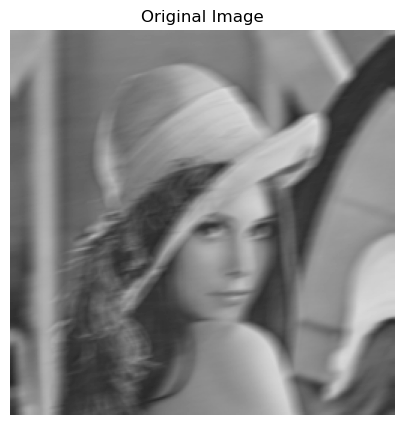

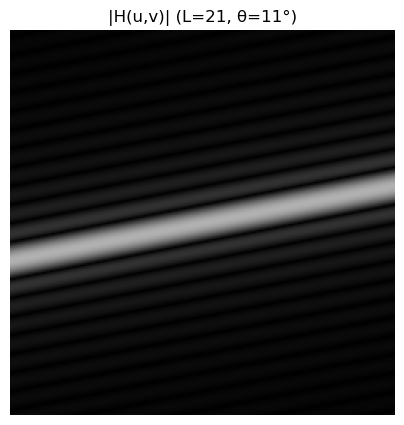

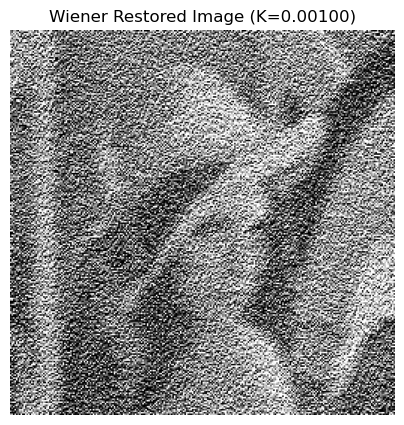

In [292]:
# ============================================================
# 6️⃣  MAIN EXECUTION
# ============================================================
img = load_image('blurred.png', size=256)  # replace None with path if needed

# Motion parameters (in pixels)
L = 21           # motion length in pixels
theta = 11       # motion direction (anticlockwise, degrees)
T = 1.0          # exposure time scale

# Generate degradation function
H = make_H_motion(*img.shape, L, theta, T)

# Wiener restoration
K = 10 ** (-snr_db / 10)
restored = wiener_restore(blurred, H, K=0.0001)

# ============================================================
# 7️⃣ Display results
# ============================================================
show(img, "Original Image")
show(np.log1p(np.abs(np.fft.fftshift(H))), f"|H(u,v)| (L={L}, θ={theta}°)")
show(restored, f"Wiener Restored Image (K={K:.5f})")

In [298]:

def wiener_restore_uniform_motion(img, L=15, theta=0, T=1.0, snr_db=30):
    """
    Wiener restoration for uniform linear motion blur.
    Uses the analytical H(u,v) model instead of PSF JSON.

    Parameters
    ----------
    img : ndarray
        Input blurred image (grayscale or RGB, range [0,1])
    L : float
        Motion blur length (pixels)
    theta : float
        Motion direction angle in degrees (anticlockwise)
    T : float
        Exposure time
    snr_db : float
        Estimated SNR in dB (used to compute K = 1/SNR)

    Returns
    -------
    restored : ndarray
        Wiener-filtered restored image
    H : ndarray
        Frequency-domain transfer function used
    """
    img = img_as_float(img)
    M, N = img.shape[:2]
    H = make_H_motion(M, N, L, theta, T)
    K = 10 ** (-snr_db / 10.0)

    def wiener_restore(blurred, H, K):
        G = np.fft.fft2(blurred)
        H_conj = np.conj(H)
        F_hat = (H_conj / (np.abs(H) ** 2 + K)) * G
        f_hat = np.fft.ifft2(F_hat).real
        return np.clip(f_hat, 0, 1)

    if img.ndim == 3:  # color
        restored = np.zeros_like(img)
        for c in range(3):
            restored[..., c] = wiener_restore(img[..., c], H, K)
    else:
        restored = wiener_restore(img, H, K)

    return restored, H

In [ ]:
# ============================================================
# 6️⃣  MAIN EXECUTION
# ============================================================
img = cv2.imread('Lena.jpg',1)

# Motion parameters (in pixels)
L = 21           # motion length in pixels
theta = 11       # motion direction (anticlockwise, degrees)
T = 1.0          # exposure time scale

# Generate degradation function
H = make_H_motion(*img.shape, L, theta, T)

# Wiener restoration
K = 10 ** (-snr_db / 10)
restored = wiener_restore(blurred, H, K=0.0001)

# ============================================================
# 7️⃣ Display results
# ============================================================
show(img, "Original Image")
show(np.log1p(np.abs(np.fft.fftshift(H))), f"|H(u,v)| (L={L}, θ={theta}°)")
show(restored, f"Wiener Restored Image (K={K:.5f})")